## Random Forest Model

In [1]:
# import libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.inspection import PartialDependenceDisplay

First we import and clean up the Parcel dataset that was created in LINK TO ALYSSA'S NOTEBOOK HERE

In [2]:
# read in data
parcel_data=pd.read_csv('data/join_scag_to_parcels_left_2019.csv')

# data clean-up
# use lambda functions to denote whether warehouse had been built on each parcel by 2010 and by 2020 (fixing error in previous version)
parcel_data['warehouse_2010']=parcel_data.year.apply(lambda x: 1 if x<2010 else 0)
parcel_data['warehouse_2020']=parcel_data.year.apply(lambda x: 1 if x<2020 else 0)
parcel_data['built_2010s']=parcel_data.year.apply(lambda x: 1 if (2010 <= x < 2020) else 0)

# replace county names w/ dummies
dummies=pd.get_dummies(parcel_data.COUNTY, prefix='county')
parcel_data = parcel_data.join(dummies)
parcel_data.head()

C:\Users\Monisha\AppData\Local\Temp\ipykernel_29044\984724337.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  parcel_data=pd.read_csv('data/join_scag_to_parcels_left_2019.csv')


,APN,LAND_VALUE,distances,building_class,year,acres,sqft,num_warehouses,warehouse_2010,warehouse_2020,...,Specific Plan,"Transportation, Communications, and Utilities",Under Construction,Undevelopable,Unknown,Vacant,Water,dollars_per_acre,county_Riverside,county_San Bernardino
0,933260003.0,48418.0,38449.033944,NaN,NaN,NaN,NaN,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2406.435207,1,0
1,933190003.0,210496.0,39355.337470,NaN,NaN,NaN,NaN,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10667.570219,1,0
2,933200001.0,347975.0,39133.409768,NaN,NaN,NaN,NaN,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,17690.981870,1,0
3,933180027.0,88468.0,39830.303362,NaN,NaN,NaN,NaN,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9505.916138,1,0
4,933180028.0,334555.0,38830.371787,NaN,NaN,NaN,NaN,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16032.116147,1,0


### Train Random Forest Model with 2010 Dataset

First we create a dataset to represent the conditions in the Inland Empire in 2010

In [3]:
# copy dataset and delete/rename variables as needed
parceldata_10=parcel_data.copy()
parceldata_10.drop(columns=['warehouse_2020'],inplace=True)
parceldata_10.rename(columns={'warehouse_2010':'warehouse_start','built_2010s':'buit_within_decade'},inplace=True)

# need to set APN to be index so that we can join this back to other information later on
parceldata_10.set_index('APN',inplace=True)

Here we set up the training model by specifying the x and y variables to use and creating a train/test split

In [4]:
# define variables 
cols=parceldata_10.columns.to_list()
xvars=[col for col in cols if col not in ('APN','building_class','year','acres','sqft','num_warehouses','buit_within_decade',
                                          'geometry','PID19','APN19','CITY','COUNTY','LU19','LU16','JURISDICTI','LU19_CLASS','SCAG_ZN_CO','Shape_Leng','Shape_Area')]
yvar = 'buit_within_decade'

# create a dataframe with no NaNs
parceldata_10_model = parceldata_10[xvars+[yvar]].dropna()

# create train-test split
X_train, X_test, y_train, y_test = train_test_split(
    parceldata_10_model[xvars], parceldata_10_model[yvar], test_size = 0.25, random_state = 1)

Now we run the model and use it to make predictions with the test dataset

In [5]:
# initialize the random forest classifer object
rf = RandomForestClassifier(n_estimators = 50, random_state = 1)

# fit the model
rf.fit(X_train, y_train)

# apply predictions to test dataset
y_pred = rf.predict(X_test)

In [6]:
# stop if the length of the predictions doesn't match the training dataset
assert len(X_test)==len(y_pred)

We used a Confusion Matrix for an initial assessment of performance

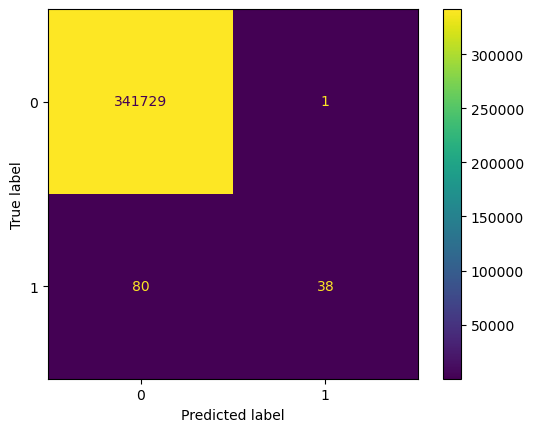

In [7]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

plt.savefig('figures/rf_confusion_nocensus.png',bbox_inches="tight",transparent=True)

In [8]:
# additional measures of fit to better understand overall model performance:
print('Predicted fraction True: {:.4f}. Actual fraction True: {:.4f}'.format(y_pred.mean(), y_test.mean()))
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, y_pred)))
print('Classification report:\n',classification_report(y_test, y_pred))

Predicted fraction True: 0.0001. Actual fraction True: 0.0003
Accuracy score: 0.9998
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    341730
           1       0.97      0.32      0.48       118

    accuracy                           1.00    341848
   macro avg       0.99      0.66      0.74    341848
weighted avg       1.00      1.00      1.00    341848



We used the feature importances to identify variables worth looking into further

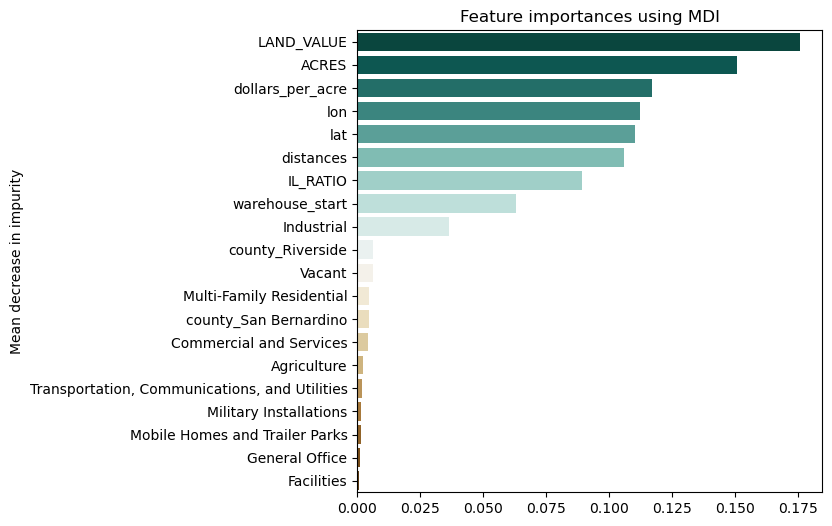

In [9]:
# create series of importances
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
forest_importances.sort_values(inplace=True, ascending=False)

# plot them
fig, ax = plt.subplots(figsize=(6,6))
sns.barplot(x=forest_importances[:20].values, y=forest_importances[:20].index, palette=sns.color_palette("BrBG_r",n_colors=20), ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

plt.savefig('figures/rf_featureimportance_nocensus.png',bbox_inches="tight",transparent=True)

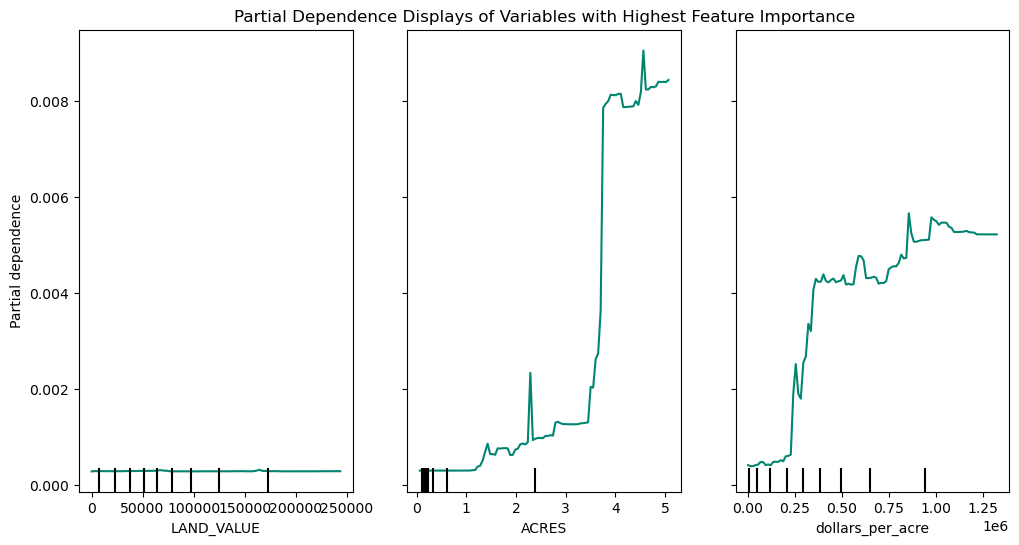

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Partial Dependence Displays of Variables with Highest Feature Importance")
mlp_disp = PartialDependenceDisplay.from_estimator(rf, X_test, forest_importances.index[:3], ax=ax, line_kw={"color": "#018571"})

plt.savefig('figures/rf_partialdependence.png',bbox_inches="tight",transparent=True)

### Apply Model to 2020 Dataset

Now we create a dataset to represent the conditions in the Inland Empire in 2020

In [11]:
# Create a dataset for data as of 2020
parceldata_20=parcel_data.copy()
parceldata_20.drop(columns=['warehouse_2010'],inplace=True)
parceldata_20.rename(columns={'warehouse_2020':'warehouse_start','built_2010s':'buit_within_decade'},inplace=True)

# need to set APN to be index so that we can join this back to other information later on
parceldata_20.set_index('APN',inplace=True)

In [12]:
# define variables 
cols=parceldata_20.columns.to_list()
xvars=[col for col in cols if col not in ('APN','building_class','year','acres','sqft','num_warehouses','buit_within_decade',
                                          'geometry','PID19','APN19','CITY','COUNTY','LU19','LU16','JURISDICTI','LU19_CLASS','SCAG_ZN_CO','Shape_Leng','Shape_Area')]
yvar = 'buit_within_decade'

# create a dataframe with no NaNs
parceldata_20_model = parceldata_20[xvars+[yvar]].dropna()

We now use the same RF model from before to predict the percent chance that a warehouse will be built within a decade on the 2020 data

In [13]:
# apply predictions from previous model to test dataset
X_test=parceldata_20_model[xvars]
y_pred = rf.predict(X_test)

In [14]:
# stop if lengths don't match
assert len(X_test)==len(y_pred)
# how many does it predict?
print('Predicted fraction True: {:.4f}'.format(y_pred.mean()))
print('Predicted number True: {:.0f}'.format(y_pred.sum()))

Predicted fraction True: 0.0000
Predicted number True: 55


We will now create a dataframe of predictions to be able to visualize the results

In [15]:
# create a dataframe of predictions about whether or not a parcel will have a warehouse built on it within 10 years & join this to the full df
predictions = pd.DataFrame(rf.predict_proba(X_test),columns = ['pred_noWH', 'pred_WH'])
predictions= predictions.join((X_test).reset_index())
predictions.set_index('APN',inplace=True)
predictions.head()

,pred_noWH,pred_WH,LAND_VALUE,distances,warehouse_start,lon,lat,ACRES,IL_RATIO,Agriculture,...,Specific Plan,"Transportation, Communications, and Utilities",Under Construction,Undevelopable,Unknown,Vacant,Water,dollars_per_acre,county_Riverside,county_San Bernardino
APN,,,,,,,,,,,,,,,,,,,,,
933260003.0,1.0,0.0,48418.0,38449.033944,0,-117.275300,33.461170,20.120218,0.38932,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2406.435207,1,0
933190003.0,1.0,0.0,210496.0,39355.337470,0,-117.276927,33.464093,19.732329,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10667.570219,1,0
933200001.0,1.0,0.0,347975.0,39133.409768,0,-117.275362,33.465158,19.669626,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,17690.981870,1,0
933180027.0,1.0,0.0,88468.0,39830.303362,0,-117.277299,33.468321,9.306625,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9505.916138,1,0
933180028.0,1.0,0.0,334555.0,38830.371787,0,-117.275263,33.469289,20.867800,0.63740,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16032.116147,1,0


In [16]:
# not a whole lot actally predicted to become warehouses... maybe visualize percentages above a certain point if census data doesn't fix
print(len(predictions[predictions.pred_WH>0.5]))
print(len(predictions[predictions.pred_WH>0.25]))

55
265
